# Training the Model

## 1. Imports

In [2]:
import matplotlib.pyplot as plt
import multiprocessing as mp
import nibabel as nib
import numpy as np
import os
import pandas as pd
import tempfile
from sklearn import metrics
import time
from time import time
import torch
from tqdm import tqdm
import monai
from monai.config import print_config
from monai.data import Dataset, DataLoader, CacheDataset
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    LoadImaged,
    MapTransform,
    Orientationd,
    RandRicianNoised,
    RandRotated,
    Resized,
    Rotate90d,
    ScaleIntensityd,
    DeleteItemsd
)


### 1.1 Set Environment Variables for GPU

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

### 1.2 Get Stored Dictionaries from CreateDataset

In [4]:
%store -r dictionary_train
%store -r dictionary_valid
%store -r dictionary_test

## 2. MONAI Dataloader

### 2.1 Data Transforms

In [11]:
#To turn 4D images to 3D (from Ashley's classifier)
class MakeSingleVolumed(MapTransform):
    def __call__(self, data):
        for key in self.keys:
            num_volumes = data[key].shape[0]
            data["NumVolumes"] = num_volumes
            
            if num_volumes != 1:
                middle_volume = num_volumes // 2
                new_data = np.empty((1,256,256,256))
                new_data[0,:,:,:] = data[key][middle_volume,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
            else:
                new_data = np.empty((1,256,256,256))
                new_data[0,:,:,:] = data[key][0,:,:,:]
                # fill last slice with the value of num_volumes 
                new_data[0,:,:,-1] = np.zeros((data[key].shape[1],data[key].shape[2])) + num_volumes
                data[key] = torch.from_numpy(new_data)
                
        return data

#This uses the mask to scale the intensity of the image
class ScaleImaged(MapTransform):
    def __call__(self, data):
            data[self.keys[0]] *= (0.4+data[self.keys[1]])

            return data


#### 2.1.1 Set Training and Validation Transforms

In [6]:
train_transforms = Compose(
    [
        LoadImaged(keys=["Flair_Image", "Flair_Mask_Image"], reader=monai.data.ITKReader, image_only=True),
        EnsureChannelFirstd(keys=["Flair_Image", "Flair_Mask_Image"]),
        Orientationd(keys=["Flair_Image", "Flair_Mask_Image"], axcodes="RAS"),        
        EnsureTyped(keys=["Flair_Image", "Flair_Mask_Image"]),
        Resized(keys=["Flair_Image", "Flair_Mask_Image"], spatial_size=(256,256,256)),
        MakeSingleVolumed(keys=["Flair_Image", "Flair_Mask_Image"]),
        Rotate90d(keys=["Flair_Image", "Flair_Mask_Image"]),
        ScaleIntensityd(keys=["Flair_Image", "Flair_Mask_Image"]),
        ScaleImaged(keys=["Flair_Image", "Flair_Mask_Image"]),
        DeleteItemsd(keys=["Flair_Mask_Image"]),
        ScaleIntensityd(keys=["Flair_Image"])
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["Flair_Image", "Flair_Mask_Image"], reader=monai.data.ITKReader, image_only=True),
        EnsureChannelFirstd(keys=["Flair_Image", "Flair_Mask_Image"]),
        Orientationd(keys=["Flair_Image", "Flair_Mask_Image"], axcodes="RAS"),        
        EnsureTyped(keys=["Flair_Image", "Flair_Mask_Image"]),
        Resized(keys=["Flair_Image", "Flair_Mask_Image"], spatial_size=(256,256,256)),
        MakeSingleVolumed(keys=["Flair_Image", "Flair_Mask_Image"]),
        Rotate90d(keys=["Flair_Image", "Flair_Mask_Image"]),
        ScaleIntensityd(keys=["Flair_Image", "Flair_Mask_Image"]),
        ScaleImaged(keys=["Flair_Image", "Flair_Mask_Image"]),
        DeleteItemsd(keys=["Flair_Mask_Image"]),
        ScaleIntensityd(keys=["Flair_Image"])
    ]
)

#### 2.1.2 Test the Transforms


In [ ]:
val_files = dictionary_valid[:10]

check_ds = Dataset(data=val_files, transform=train_transforms)
check_DataLoader = DataLoader(check_ds, batch_size=1, shuffle=False)

In [ ]:
program_starts = time()
step = 1350
print('here1')
for item in check_DataLoader:
    print('here2')
    input_images,  label, path = item["Flair_Image"], item["MGMT"], item["Flair_Path"]
    print('here3')
    try:
        print(f"{step} - input_images shape: {input_images.shape}")
        print(f"Path - {path}")
        plt.title("Image")
        plt.axis('off')
        plt.imshow(np.squeeze(input_images[0,0,:,:,64]), cmap="gray")
        plt.show()
    except:
        print(' ERROR !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    step += 1
now = time()
print("It has been {0} seconds since the loop started".format(now - program_starts))

## 2.2 Create Train/Valid/Test DataLoaders

In [7]:
print(os.cpu_count())

train_ds = CacheDataset(data=dictionary_train, transform=train_transforms, cache_num=1024, num_workers=os.cpu_count())
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=os.cpu_count())

valid_ds = CacheDataset(data=dictionary_valid, transform=val_transforms, cache_num=1024, num_workers=os.cpu_count())
valid_loader = DataLoader(valid_ds, batch_size=4, shuffle=False, num_workers=os.cpu_count())

test_ds = CacheDataset(data=dictionary_test, transform=val_transforms, cache_num=1024, num_workers=os.cpu_count())
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=os.cpu_count())

20


Loading dataset: 100%|████████████████████████| 125/125 [00:46<00:00,  2.71it/s]


## 3. DenseNet Model (for now)

### 3.1 Model and Device Setup


In [8]:
# Use GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = monai.networks.nets.DenseNet201(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
)

# If multiple GPUs are available, run in parallel
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)
model.to(device)

# There's more negative in our train set than positive, so weigh the positive higher in loss function
loss_weights = torch.tensor([1.3]).to(device)
loss_function = torch.nn.BCEWithLogitsLoss(pos_weight=loss_weights)



optimizer = torch.optim.Adam(model.parameters(), 1e-6)

cuda
Let's use 4 GPUs!


#### 3.1.1 Helper Function to Visualize Training Curves

In [9]:
def plot_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure("train", (12, 12))

    plt.subplot(2, 1, 1)
    plt.title("Epoch Average Loss")
    x = [i + 1 for i in range(len(train_loss))]
    x = x[1:]
    y = train_loss
    y = y[1:]
    plt.xlabel("epoch")
    plt.plot(x, y)
    x = [i + 1 for i in range(len(val_loss))]
    x = x[1:]
    y = val_loss
    y = y[1:]
    plt.plot(x, y)
    plt.legend(('Training', 'Validation'))


    plt.subplot(2, 1, 2)
    plt.title("Accuracy")
    x = [(i + 1) for i in range(len(train_acc))]
    y = train_acc
    plt.xlabel("epoch")
    plt.plot(x, y)
    x = [(i + 1) for i in range(len(val_acc))]
    y = val_acc
    plt.plot(x, y)
    plt.legend(('Training', 'Validation'))
    
    plt.show()

### 3.2 Training

----------
epoch 1/15


Epoch : 100%|████| 251/251 [04:29<00:00,  1.08s/it, Overall Training Loss=0.812]


saved new best metric model
current epoch: 1 current avg accuracy: 0.5360 best accuracy: 0.5360 at epoch 1
Num guessed positive: 
1004
train accuracy: 0.4153 validation accuracy: 0.5360 train loss: 0.7848 validation loss 0.7803
----------
epoch 2/15


Epoch : 100%|████| 251/251 [04:31<00:00,  1.08s/it, Overall Training Loss=0.784]


saved new best metric model
current epoch: 2 current avg accuracy: 0.5520 best accuracy: 0.5520 at epoch 2
Num guessed positive: 
894
train accuracy: 0.4572 validation accuracy: 0.5520 train loss: 0.7778 validation loss 0.7782
----------
epoch 3/15


Epoch : 100%|████| 251/251 [04:31<00:00,  1.08s/it, Overall Training Loss=0.928]


saved new best metric model
current epoch: 3 current avg accuracy: 0.5920 best accuracy: 0.5920 at epoch 3
Num guessed positive: 
467
train accuracy: 0.6016 validation accuracy: 0.5920 train loss: 0.7743 validation loss 0.7815
----------
epoch 4/15


Epoch : 100%|████| 251/251 [04:33<00:00,  1.09s/it, Overall Training Loss=0.654]


current epoch: 4 current avg accuracy: 0.5840 best accuracy: 0.5920 at epoch 3
Num guessed positive: 
318
train accuracy: 0.6464 validation accuracy: 0.5840 train loss: 0.7718 validation loss 0.7786
----------
epoch 5/15


Epoch : 100%|████| 251/251 [04:34<00:00,  1.09s/it, Overall Training Loss=0.832]


current epoch: 5 current avg accuracy: 0.5920 best accuracy: 0.5920 at epoch 3
Num guessed positive: 
244
train accuracy: 0.6564 validation accuracy: 0.5920 train loss: 0.7699 validation loss 0.7833


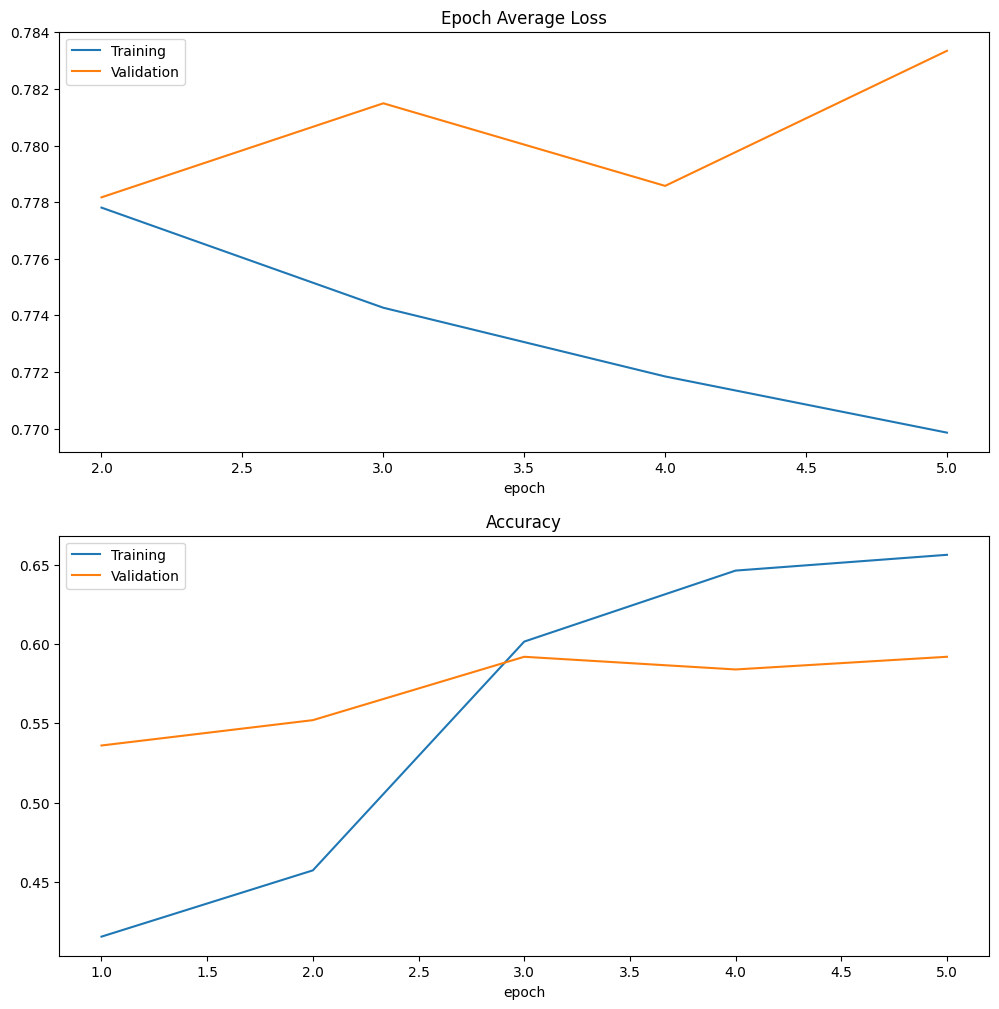

----------
epoch 6/15


Epoch : 100%|████| 251/251 [04:32<00:00,  1.08s/it, Overall Training Loss=0.708]


saved new best metric model
current epoch: 6 current avg accuracy: 0.6080 best accuracy: 0.6080 at epoch 6
Num guessed positive: 
135
train accuracy: 0.6295 validation accuracy: 0.6080 train loss: 0.7681 validation loss 0.7798
----------
epoch 7/15


Epoch : 100%|█████| 251/251 [04:31<00:00,  1.08s/it, Overall Training Loss=0.86]


current epoch: 7 current avg accuracy: 0.5920 best accuracy: 0.6080 at epoch 6
Num guessed positive: 
200
train accuracy: 0.6424 validation accuracy: 0.5920 train loss: 0.7665 validation loss 0.7826
----------
epoch 8/15


Epoch : 100%|████| 251/251 [04:35<00:00,  1.10s/it, Overall Training Loss=0.789]


saved new best metric model
current epoch: 8 current avg accuracy: 0.6160 best accuracy: 0.6160 at epoch 8
Num guessed positive: 
188
train accuracy: 0.6524 validation accuracy: 0.6160 train loss: 0.7650 validation loss 0.7848
----------
epoch 9/15


Epoch : 100%|████| 251/251 [04:38<00:00,  1.11s/it, Overall Training Loss=0.708]


saved new best metric model
current epoch: 9 current avg accuracy: 0.6400 best accuracy: 0.6400 at epoch 9
Num guessed positive: 
235
train accuracy: 0.6673 validation accuracy: 0.6400 train loss: 0.7636 validation loss 0.7806
----------
epoch 10/15


Epoch : 100%|████| 251/251 [04:38<00:00,  1.11s/it, Overall Training Loss=0.675]


current epoch: 10 current avg accuracy: 0.5920 best accuracy: 0.6400 at epoch 9
Num guessed positive: 
262
train accuracy: 0.6624 validation accuracy: 0.5920 train loss: 0.7622 validation loss 0.7818


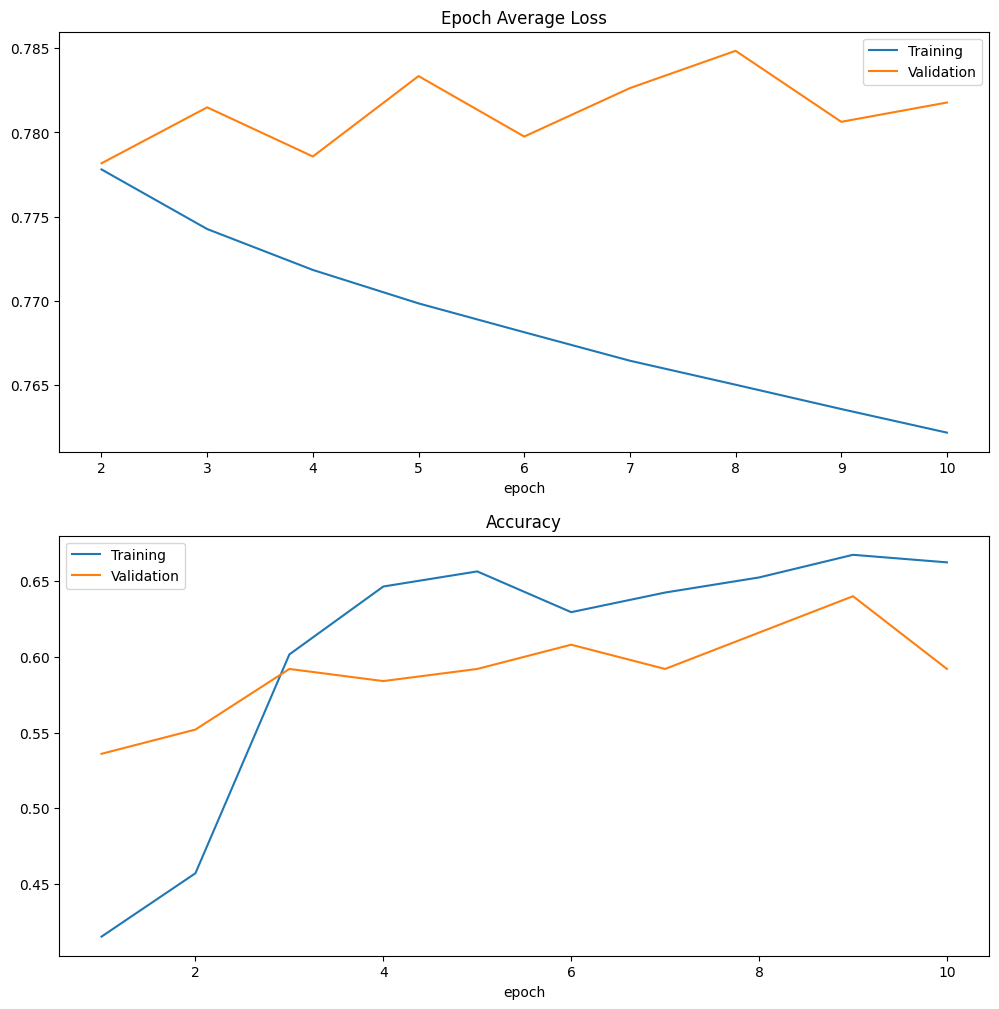

----------
epoch 11/15


Epoch : 100%|█████| 251/251 [04:36<00:00,  1.10s/it, Overall Training Loss=0.72]


current epoch: 11 current avg accuracy: 0.5840 best accuracy: 0.6400 at epoch 9
Num guessed positive: 
190
train accuracy: 0.6643 validation accuracy: 0.5840 train loss: 0.7608 validation loss 0.7776
----------
epoch 12/15


Epoch : 100%|████| 251/251 [04:34<00:00,  1.09s/it, Overall Training Loss=0.734]


current epoch: 12 current avg accuracy: 0.5840 best accuracy: 0.6400 at epoch 9
Num guessed positive: 
252
train accuracy: 0.6803 validation accuracy: 0.5840 train loss: 0.7596 validation loss 0.7847
----------
epoch 13/15


Epoch : 100%|████| 251/251 [05:20<00:00,  1.28s/it, Overall Training Loss=0.827]


current epoch: 13 current avg accuracy: 0.6080 best accuracy: 0.6400 at epoch 9
Num guessed positive: 
267
train accuracy: 0.6833 validation accuracy: 0.6080 train loss: 0.7583 validation loss 0.7887
----------
epoch 14/15


Epoch : 100%|████| 251/251 [04:36<00:00,  1.10s/it, Overall Training Loss=0.893]


current epoch: 14 current avg accuracy: 0.6160 best accuracy: 0.6400 at epoch 9
Num guessed positive: 
268
train accuracy: 0.6823 validation accuracy: 0.6160 train loss: 0.7570 validation loss 0.7800
----------
epoch 15/15


Epoch : 100%|████| 251/251 [04:35<00:00,  1.10s/it, Overall Training Loss=0.777]


current epoch: 15 current avg accuracy: 0.5760 best accuracy: 0.6400 at epoch 9
Num guessed positive: 
323
train accuracy: 0.6753 validation accuracy: 0.5760 train loss: 0.7558 validation loss 0.7924


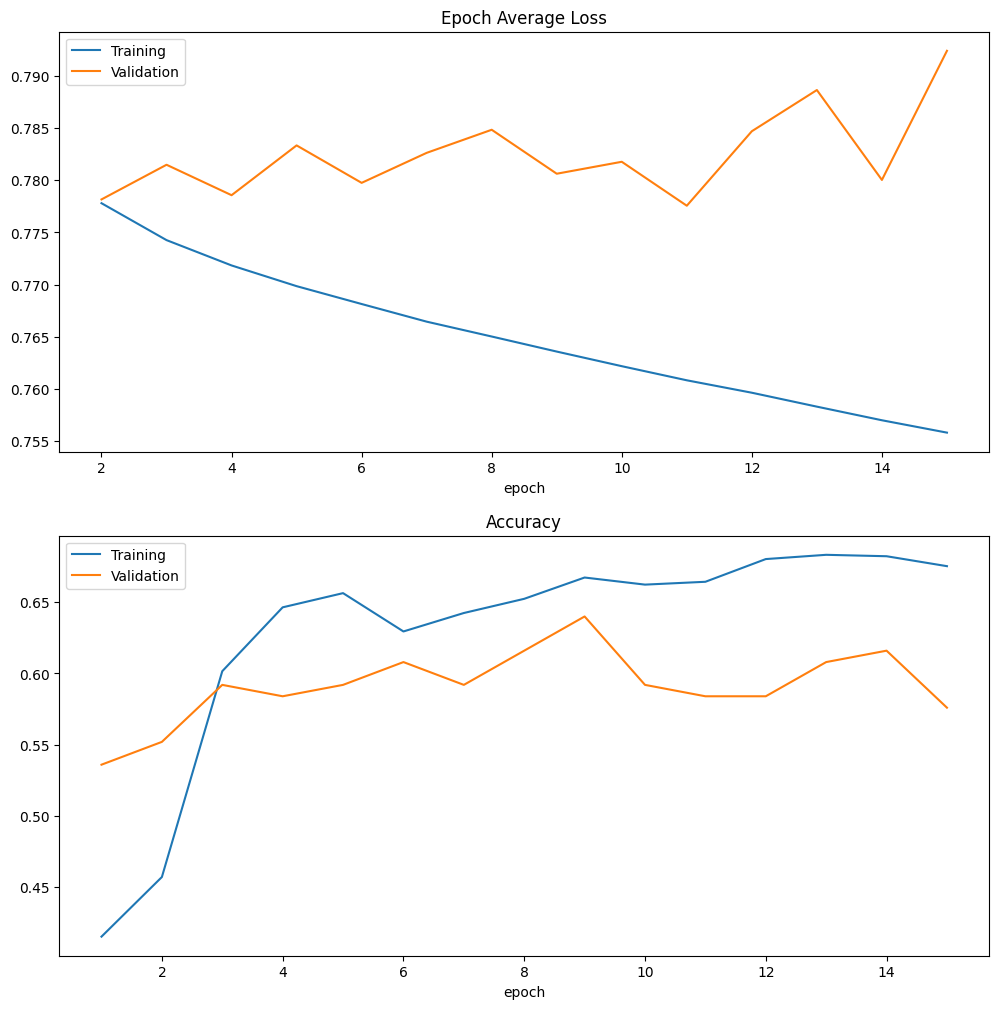

train completed, best_metric: 0.6400 at epoch: 9


In [10]:
val_interval = 1    # validate at every n epochs
graph_interval = 5    # plot training graphs every n epochs

best_metric = -1    # default value
best_metric_epoch = -1    # default value

# arrays to keep track of loss and accuracy for plotting curves
train_loss = []
val_loss = []
train_acc = []
val_acc = []


train_acc = []
val_acc = []

num_epochs = 10

torch.cuda.empty_cache()

for epoch in range(num_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{num_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    
    num_correct = 0.0
    metric_count = 0
    num_guessed_positive = 0
    
    # TRAINING
    # using tqdm will show progress bar for each epoch
    with tqdm(train_loader, desc=("Epoch ")) as pbar:
        # iterate through train_loader batches
        for i, batch_data in enumerate(pbar):
            step += 1
            image, labels = batch_data["Flair_Image"].to(device, dtype=torch.float), torch.from_numpy(np.asarray(batch_data["MGMT"]).astype('int64')).to(device).unsqueeze(1).float()
            optimizer.zero_grad()
            output = model(image)
            loss = loss_function(output, labels)
            loss.backward()
            optimizer.step()
            
            # values for calculating accuracy
            threshold = torch.tensor([0.5]).to(device)
            num_guessed_positive += (torch.sigmoid(output) > threshold).sum().item()
            value = torch.eq((torch.sigmoid(output) > threshold).float()*1, labels)
            metric_count += len(value)
            num_correct += value.sum().item()    
            
            # epoch loss
            epoch_loss += loss.item()
                                                                                      
            epoch_len = len(train_ds) // train_loader.batch_size
            
            # update progress bar to display loss
            pbar.set_postfix({'Overall Training Loss': loss.item()})
            
        # append loss and accuracy
        epoch_loss /= step
        train_loss.append(epoch_loss)
        metric = num_correct / metric_count
        train_acc.append(metric)
    
        # VALIDATION
        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():

                y_pred = torch.tensor([], dtype=torch.float32, device=device)
                y = torch.tensor([], dtype=torch.long, device=device)
                                                                
                
                # iterate through valid_loader batches
                for i, val_data in enumerate(valid_loader):
                    val_flair, val_labels = val_data["Flair_Image"].to(device, dtype=torch.float), torch.from_numpy(np.asarray(val_data["MGMT"]).astype('int64')).to(device)
                    output = model(val_flair)
                    y_pred = torch.cat([y_pred, output], dim=0)
                    y = torch.cat([y, val_labels], dim=0)
                    
                # calculate and append loss
                loss = loss_function(y_pred, y.float().unsqueeze(1))
                val_loss.append(loss.item())


                
                # calculate and append accuracy
                threshold = torch.tensor([0.5]).to(device)
                acc_value = torch.eq((torch.sigmoid(y_pred) > threshold).float()*1, y.float().unsqueeze(1))
                acc_metric = (acc_value.sum().item()) / len(acc_value)
                val_acc.append(acc_metric)


                # update best metric
                if acc_metric > best_metric:
                    best_metric = acc_metric
                    best_metric_epoch = epoch + 1
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss,
                        'train_loss_arr': train_loss,
                        'val_loss_arr': val_loss,
                        'train_acc_arr': train_acc,
                        'val_acc_arr': val_acc,
                        'val_acc': val_acc,
                        'train_acc': train_acc,
                        }, "best_metric_densenet.pth")
                    print("saved new best metric model")
                print(
                    "current epoch: {} current avg accuracy: {:.4f} best accuracy: {:.4f} at epoch {}".format(
                        epoch + 1, acc_metric, best_metric, best_metric_epoch
                    )
                )
                print("Num guessed positive: ")
                print(num_guessed_positive)
                print(
                    "train accuracy: {:.4f} validation accuracy: {:.4f} train loss: {:.4f} validation loss {:.4f}".format(
                        train_acc[-1], acc_metric, train_loss[-1],loss.item()
                    )
                )
                
        # display train/validation curves
        if (epoch + 1) % graph_interval == 0:
            plot_curves(train_loss, val_loss, train_acc, val_acc)
        
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

## 4. Evaluating Results

### 4.1 Evaluating the Model on the Test Dataset

In [14]:
torch.cuda.empty_cache()

saved_dict = torch.load("best_metric_densenet.pth")
model.load_state_dict(saved_dict['model_state_dict'])
model.eval()
y_true = []
y_pred = []
y_probs = []


with tqdm(test_loader, desc=("Loading ")) as pbar:
    with torch.no_grad():
        for test_data in pbar:
            test_images, test_labels = (
                test_data["Flair_Image"].to(device, dtype=torch.float),
                torch.from_numpy(np.asarray(test_data["MGMT"]).astype('int64')).to(device)
            )

            output = torch.sigmoid(model(test_images))
            print(output)
            probs = (output > 0.5)

            y_probs.extend(probs)

            for i in range(len(output)):
                y_true.append(test_labels[i].item())
                y_pred.append(probs[i].item())


Loading :   3%|█                                 | 1/32 [00:30<15:51, 30.69s/it]

tensor([[0.4957],
        [0.5231],
        [0.4861],
        [0.5228]], device='cuda:0')


Loading :   6%|██▏                               | 2/32 [00:31<06:26, 12.89s/it]

tensor([[0.5168],
        [0.4879],
        [0.5311],
        [0.5017]], device='cuda:0')


Loading :   9%|███▏                              | 3/32 [00:31<03:28,  7.20s/it]

tensor([[0.4884],
        [0.4635],
        [0.5049],
        [0.5050]], device='cuda:0')


Loading :  12%|████▎                             | 4/32 [00:31<02:06,  4.51s/it]

tensor([[0.4938],
        [0.4907],
        [0.5649],
        [0.4920]], device='cuda:0')


Loading :  16%|█████▎                            | 5/32 [00:32<01:21,  3.03s/it]

tensor([[0.4916],
        [0.4632],
        [0.4712],
        [0.4556]], device='cuda:0')


Loading :  19%|██████▍                           | 6/32 [00:32<00:55,  2.14s/it]

tensor([[0.5176],
        [0.4817],
        [0.4560],
        [0.4532]], device='cuda:0')


Loading :  22%|███████▍                          | 7/32 [00:33<00:41,  1.68s/it]

tensor([[0.4997],
        [0.4770],
        [0.4808],
        [0.4915]], device='cuda:0')


Loading :  25%|████████▌                         | 8/32 [00:33<00:30,  1.28s/it]

tensor([[0.4437],
        [0.4683],
        [0.4958],
        [0.5003]], device='cuda:0')


Loading :  28%|█████████▌                        | 9/32 [00:34<00:23,  1.00s/it]

tensor([[0.4606],
        [0.5298],
        [0.5479],
        [0.4896]], device='cuda:0')


Loading :  31%|██████████▎                      | 10/32 [00:34<00:18,  1.22it/s]

tensor([[0.5480],
        [0.4509],
        [0.5122],
        [0.5025]], device='cuda:0')


Loading :  34%|███████████▎                     | 11/32 [00:35<00:14,  1.43it/s]

tensor([[0.5042],
        [0.5608],
        [0.4978],
        [0.5121]], device='cuda:0')


Loading :  38%|████████████▍                    | 12/32 [00:35<00:12,  1.66it/s]

tensor([[0.4895],
        [0.4771],
        [0.5147],
        [0.5193]], device='cuda:0')


Loading :  41%|█████████████▍                   | 13/32 [00:35<00:10,  1.87it/s]

tensor([[0.4628],
        [0.4779],
        [0.4504],
        [0.5407]], device='cuda:0')


Loading :  44%|██████████████▍                  | 14/32 [00:36<00:08,  2.04it/s]

tensor([[0.4651],
        [0.4870],
        [0.4874],
        [0.5646]], device='cuda:0')


Loading :  47%|███████████████▍                 | 15/32 [00:36<00:07,  2.16it/s]

tensor([[0.4513],
        [0.4642],
        [0.4823],
        [0.4680]], device='cuda:0')


Loading :  50%|████████████████▌                | 16/32 [00:37<00:07,  2.26it/s]

tensor([[0.5397],
        [0.4873],
        [0.5577],
        [0.5331]], device='cuda:0')


Loading :  53%|█████████████████▌               | 17/32 [00:37<00:07,  2.03it/s]

tensor([[0.4775],
        [0.5939],
        [0.4795],
        [0.4815]], device='cuda:0')


Loading :  56%|██████████████████▌              | 18/32 [00:38<00:06,  2.13it/s]

tensor([[0.4940],
        [0.4574],
        [0.4957],
        [0.5398]], device='cuda:0')


Loading :  59%|███████████████████▌             | 19/32 [00:38<00:05,  2.23it/s]

tensor([[0.4810],
        [0.5478],
        [0.4890],
        [0.4724]], device='cuda:0')


Loading :  62%|████████████████████▋            | 20/32 [00:38<00:05,  2.32it/s]

tensor([[0.5630],
        [0.4804],
        [0.4938],
        [0.4620]], device='cuda:0')


Loading :  66%|█████████████████████▋           | 21/32 [00:39<00:04,  2.35it/s]

tensor([[0.5431],
        [0.4506],
        [0.4603],
        [0.4773]], device='cuda:0')


Loading :  69%|██████████████████████▋          | 22/32 [00:39<00:04,  2.39it/s]

tensor([[0.4521],
        [0.4857],
        [0.5255],
        [0.4715]], device='cuda:0')


Loading :  72%|███████████████████████▋         | 23/32 [00:40<00:03,  2.42it/s]

tensor([[0.4939],
        [0.4954],
        [0.5076],
        [0.5225]], device='cuda:0')


Loading :  75%|████████████████████████▊        | 24/32 [00:40<00:03,  2.48it/s]

tensor([[0.4976],
        [0.4704],
        [0.5164],
        [0.4651]], device='cuda:0')


Loading :  78%|█████████████████████████▊       | 25/32 [00:40<00:02,  2.52it/s]

tensor([[0.5321],
        [0.4907],
        [0.4885],
        [0.4621]], device='cuda:0')


Loading :  81%|██████████████████████████▊      | 26/32 [00:41<00:02,  2.54it/s]

tensor([[0.4603],
        [0.5496],
        [0.5050],
        [0.4719]], device='cuda:0')


Loading :  84%|███████████████████████████▊     | 27/32 [00:41<00:02,  2.19it/s]

tensor([[0.5132],
        [0.4948],
        [0.4920],
        [0.4655]], device='cuda:0')


Loading :  88%|████████████████████████████▉    | 28/32 [00:42<00:01,  2.30it/s]

tensor([[0.4701],
        [0.4798],
        [0.5268],
        [0.4787]], device='cuda:0')


Loading :  91%|█████████████████████████████▉   | 29/32 [00:42<00:01,  2.38it/s]

tensor([[0.5557],
        [0.4679],
        [0.5179],
        [0.5102]], device='cuda:0')


Loading :  94%|██████████████████████████████▉  | 30/32 [00:43<00:00,  2.43it/s]

tensor([[0.4860],
        [0.5179],
        [0.5387],
        [0.4792]], device='cuda:0')


Loading :  97%|███████████████████████████████▉ | 31/32 [00:43<00:00,  2.44it/s]

tensor([[0.4608],
        [0.5507],
        [0.4920],
        [0.4973]], device='cuda:0')


Loading : 100%|█████████████████████████████████| 32/32 [00:43<00:00,  2.77it/s]

tensor([[0.4740]], device='cuda:0')


Loading : 100%|█████████████████████████████████| 32/32 [00:46<00:00,  1.46s/it]


#### 4.1.2 Classification Report

In [15]:
print(metrics.classification_report(y_true, y_pred, target_names=["UNMETHYLATED", "METHYLATED"], digits=4))

              precision    recall  f1-score   support

UNMETHYLATED     0.6000    0.6857    0.6400        70
  METHYLATED     0.5111    0.4182    0.4600        55

    accuracy                         0.5680       125
   macro avg     0.5556    0.5519    0.5500       125
weighted avg     0.5609    0.5680    0.5608       125



#### 4.1.3 Confusion Matrix

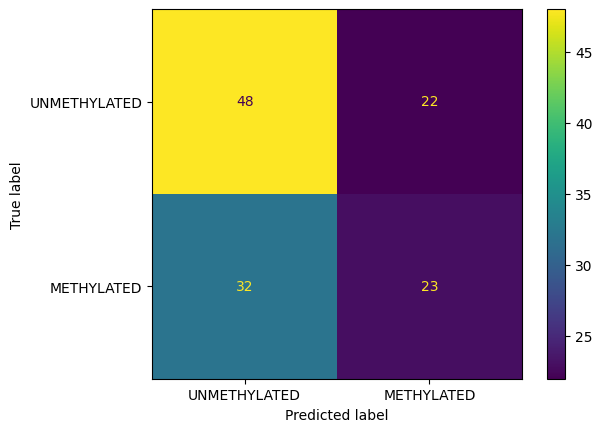

In [16]:
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["UNMETHYLATED", "METHYLATED"])
cm_display.plot()
plt.show()

In [1]:
# Not sure how much better this will get without the T1 images

%reset -f